# Design optimization of a bilayer SiN/Si grating coupler

Silicon nitride has attracted increasing interest due to its superior passive properties. However, similar to silicon PICs, fiber-to-chip coupling remains a significant challenge for SiN platforms. Conventional SiN grating couplers exhibit low coupling efficiency due to their low refractive index contrast. To address this, a high-contrast grating reflector (GR) is employed as a bottom reflector to enhance coupling efficiency, rather than using distributed Bragg reflectors (DBR) or metal reflectors. Through design optimization, combining parameter sweeps and adjoint-based inverse design, a grating coupler with high coupling efficiency (< 1 dB) is achieved.

The workflow includes:
1.  **Periodic SiN Grating Coupler Design**: Optimizing the SiN grating period, gap size, and fiber position.
2.  **Silicon Grating Reflector Design**: Designing a bottom silicon grating to reflect leakage light upwards.
3.  **Interlayer Distance Optimization**: Tuning the distance between the SiN and Si layers.
4.  **Inverse Design**: Using adjoint optimization to apodize the grating for maximum efficiency.

<center><img src="img/bilayer_GC.png" alt="schematic"  width="500"/></center>

The design is based on the following publication: `Jinghui Zou, Yu Yu, Mengyuan Ye, Lei Liu, Shupeng Deng, and Xinliang Zhang, "Ultra efficient silicon nitride grating coupler with bottom grating reflector," Opt. Express 23, 26305-26312 (2015).` [DOI: 10.1364/OE.23.026305](https://doi.org/10.1364/OE.23.026305).

In [1]:
import autograd as ag
import autograd.numpy as np
import matplotlib.pyplot as plt
import optax
import tidy3d as td
import tidy3d.plugins.design as tdd
import tidy3d.web as web

## Simulation Setup
We define the central wavelength, frequency, and bandwidth for the simulation. The simulation will target 1550 nm.

In [2]:
lda0 = 1.55  # Central wavelength
freq0 = td.C_0 / lda0  # Central frequency
ldas = np.linspace(1.5, 1.6, 101)  # Wavelength range
freqs = td.C_0 / ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # Frequency width of the source

We define the relevant materials as nondispersive mediums for simplicity.

In [3]:
SiN = td.Medium.from_nk(n=1.97, k=0, freq=freq0)
Si = td.Medium.from_nk(n=3.47, k=0, freq=freq0)
SiO2 = td.Medium.from_nk(n=1.44, k=0, freq=freq0)

Defining the fixed geometric parameters.

In [4]:
t_SiN = 0.4  # Thickness of SiN layer
t_Si = 0.22  # Thickness of Silicon waveguide
t_clad = 0.75  # Target cladding thickness
t_box = 2  # Thickness of Buried Oxide (BOX)
theta = np.deg2rad(8)  # Fiber angle
mfd = 10.4  # Mode field diameter

n_gc = 14  # Number of SiN grating teeth
inf_eff = 1e3  # Effective infinity

Next we define some fixed simulation parameters. These will be used repeatedly in various following simulation setups.

In [5]:
run_time = 3e-12  # Simulation run time

# Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20)

# Boundary condition specification
boundary_spec = td.BoundarySpec(
    x=td.Boundary.absorber(num_layers=80),
    y=td.Boundary.periodic(),  # set the boundary to periodic in y since it's a 2D simulation
    z=td.Boundary.pml(),
)

# Mode monitor for coupling efficiency measurement
mode_monitor = td.ModeMonitor(
    center=(-lda0 / 2, 0, t_SiN / 2),
    size=(0, td.inf, 5 * t_SiN),
    freqs=freqs,
    mode_spec=td.ModeSpec(num_modes=1, target_neff=1.97),
    name="mode",
)

## Periodic SiN Grating Coupler Design

In the first part, we design and optimize a periodic SiN grating coupler by parameter sweeping the grating period, duty cycle, and fiber position. 

Since we are optimizing the grating only, we will ignore the silicon layer as well as the substrate for now. They will be added and optimized later.

<center><img src="img/bilayer_GC_2.png" alt="schematic"  width="500"/></center>

In [6]:
def make_2D_SiN_grating(w_gc: float, p_gc: float) -> td.Structure:
    """
    Creates a 2D SiN grating structure.

    Parameters:
        w_gc (float): Width of the etched region.
        p_gc (float): Period of the grating.

    Returns:
        td.Structure: The resulting grating structure.
    """
    gratings = 0
    # Iterate to create each period of the grating
    for i in range(n_gc):
        # Add a box for each grating period
        gratings += td.Box.from_bounds(
            rmin=(w_gc + i * p_gc, -inf_eff, 0), rmax=((i + 1) * p_gc, inf_eff, t_SiN)
        )

    return td.Structure(geometry=gratings, medium=SiN)


waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(0, inf_eff, t_SiN)),
    medium=SiN,
)

oxide_layer = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, t_SiN + t_clad)
    ),
    medium=SiO2,
)


def make_2D_SiN_grating_sim(w_gc: float, p_gc: float, x_fiber: float) -> td.Simulation:
    """
    Creates a simulation for a 2D SiN grating coupler.

    Parameters:
        w_gc (float): Width of the etched region.
        p_gc (float): Period of the grating.
        x_fiber (float): x-position of the fiber center.

    Returns:
        td.Simulation: The Tidy3D simulation object.
    """
    gratings = make_2D_SiN_grating(w_gc, p_gc)  # Create the grating structure

    # Create a Gaussian beam source representing the input fiber mode
    gaussian_beam = td.GaussianBeam(
        center=(x_fiber, 0, t_SiN + t_clad + lda0 / 4),
        size=(2 * mfd, td.inf, 0),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        pol_angle=np.pi / 2,
        angle_theta=theta,
        angle_phi=0,
        direction="-",
        waist_radius=mfd / 2,
        waist_distance=0,
    )

    # Simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-lda0, 0, -lda0), rmax=(n_gc * p_gc + lda0, 0, t_SiN + t_clad + lda0)
    )

    # Create the simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=grid_spec,
        run_time=run_time,
        structures=[oxide_layer, gratings, waveguide],
        sources=[gaussian_beam],
        monitors=[mode_monitor],
        boundary_spec=boundary_spec,
    )
    return sim

Create a single simulation to verify the setup and visualize the permittivity distribution.

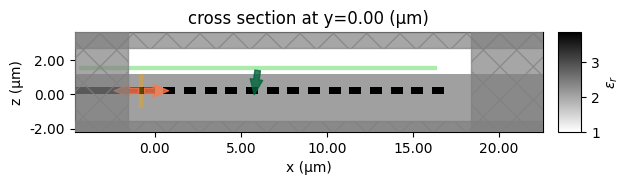

In [7]:
sim = make_2D_SiN_grating_sim(w_gc=0.5, p_gc=1.2, x_fiber=6)
sim.plot_eps(y=0)
plt.show()

In [8]:
def coupling_efficiency(sim_data: td.SimulationData) -> dict:
    """
    Calculates the coupling efficiency from simulation data.

    Parameters
    ----------
    sim_data : td.SimulationData
        The simulation data containing mode amplitudes.

    Returns
    -------
    dict
        A dictionary containing the coupling efficiency in dB.
    """
    # Extract the amplitude of the fundamental mode (mode_index=0) propagating in the backward direction ("-") at the central frequency (freq0)
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="-", f=freq0).values
    return {"coupling efficiency": 20 * np.log10(np.abs(amp))}

Now we are ready to perform the parameter sweep (grid search) using Tidy3D's `Design` plugin. 

In [9]:
# Define parameters and bounds
params = [
    tdd.ParameterFloat(name="w_gc", span=(0.4, 0.5), num_points=6),
    tdd.ParameterFloat(name="p_gc", span=(1.0, 1.2), num_points=6),
    tdd.ParameterFloat(name="x_fiber", span=(4.8, 5.2), num_points=5),
]

# Design optimization method (grid search)
method = tdd.MethodGrid()

# Create a design space and run the sweep
design_space = tdd.DesignSpace(method=method, parameters=params, path_dir="./data")
results = design_space.run(make_2D_SiN_grating_sim, coupling_efficiency)

11:39:50 Eastern Standard Time Running 180 Simulations

After the sweep is done, we can pick the optimal design parameters. 

In [10]:
df = results.to_dataframe()  # Convert the results to a pandas DataFrame

# Pick the best design
best_row = df.loc[df["coupling efficiency"].idxmax()]
best_w_gc, best_p_gc, best_x_fiber = best_row[["w_gc", "p_gc", "x_fiber"]]
df.sort_values(by="coupling efficiency", ascending=False)

w_gc  p_gc  x_fiber  coupling efficiency
72   0.44  1.08      5.0            -5.882929
73   0.44  1.08      5.1            -5.883616
71   0.44  1.08      4.9            -5.884305
74   0.44  1.08      5.2            -5.886312
70   0.44  1.08      4.8            -5.887364
..    ...   ...      ...                  ...
150  0.40  1.20      4.8           -24.129137
151  0.40  1.20      4.9           -24.406663
152  0.40  1.20      5.0           -24.685795
153  0.40  1.20      5.1           -24.970030
154  0.40  1.20      5.2           -25.254913

[180 rows x 4 columns]

## Periodic Si Grating Reflector Design
To improve the coupling efficiency of the grating coupler, we add a bottom grating in the silicon layer to reflect leakage light upwards. We need to optimize the grating period and duty cycle to achieve maximum reflection.

In [11]:
def make_2D_Si_grating(w_gr: float, p_gr: float, z_gr: float) -> "td.Structure":
    """
    Creates a 2D silicon grating structure.

    Args:
        w_gr: Width of the etched region.
        p_gr: Period of the grating.
        z_gr: The z-coordinate of the bottom surface of the grating.

    Returns:
        A Tidy3D Structure object representing the entire grating.
    """
    offset = -2  # Initial offset for the grating placement

    # Loop to create multiple grating teeth
    gratings = 0
    for i in range(50):
        gratings += td.Box.from_bounds(
            rmin=(offset + w_gr + i * p_gr, -inf_eff, -z_gr),
            rmax=(offset + (i + 1) * p_gr, inf_eff, -z_gr + t_Si),
        )

    return td.Structure(geometry=gratings, medium=Si)


# Create a Gaussian beam at the optimal position
gaussian_beam = td.GaussianBeam(
    center=(best_x_fiber, 0, t_SiN + t_clad + lda0 / 4),
    size=(2 * mfd, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    pol_angle=np.pi / 2,
    angle_theta=theta,
    angle_phi=0,
    direction="-",
    waist_radius=mfd / 2,
    waist_distance=0,
)


def make_2D_Si_grating_sim(w_gr: float, p_gr: float, z_gr: float = 1) -> "td.Simulation":
    """
    Creates a Tidy3D simulation for a 2D silicon grating.

    Args:
        w_gr: Width of the etched region.
        p_gr: Period of the grating.
        z_gr: The z-coordinate of the bottom surface of the grating.

    Returns:
        A Tidy3D Simulation object.
    """
    # Create the grating structure
    gratings = make_2D_Si_grating(w_gr, p_gr, z_gr)

    # Define the substrate structure
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -z_gr - t_box)
        ),
        medium=Si,
    )

    # Define a flux monitor to measure reflection
    flux_monitor = td.FluxMonitor(
        center=(0, 0, t_SiN + t_clad + lda0 / 2),
        size=(td.inf, td.inf, 0),
        freqs=[freq0],
        normal_dir="+",
        name="flux",
    )

    # Simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-lda0, 0, -z_gr - t_box - lda0),
        rmax=(20 * p_gr + lda0, 0, t_SiN + t_clad + lda0),
    )

    # Create the simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=grid_spec,
        run_time=run_time,
        structures=[oxide_layer, gratings, substrate],
        sources=[gaussian_beam],
        monitors=[flux_monitor],
        boundary_spec=boundary_spec,
    )
    return sim

Visualize the simulation setup.

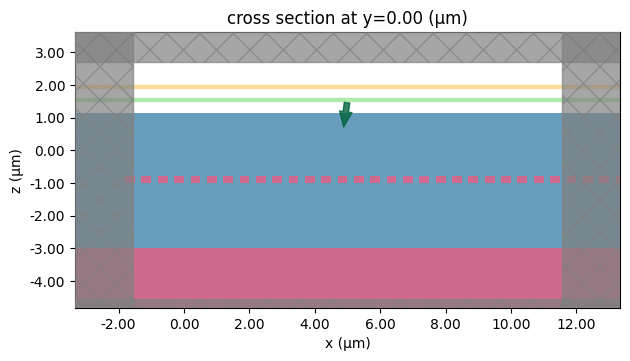

In [12]:
sim = make_2D_Si_grating_sim(w_gr=0.2, p_gr=0.5)
sim.plot(y=0)
plt.show()

In [13]:
def reflectivity(sim_data: td.SimulationData) -> dict:
    """
    Extracts the reflectivity from the simulation data.

    Parameters:
        sim_data (td.SimulationData): The simulation data containing flux results.

    Returns:
        dict: A dictionary containing the reflectivity values.
    """
    # Extract the flux values from the simulation data
    r = sim_data["flux"].flux.values
    return {"reflectivity": r}

Similar to the previous section, we will perform a parameter sweep to optimize the Si grating period and duty cycle.

In [14]:
# Design parameters and bounds
params = [
    tdd.ParameterFloat(name="w_gr", span=(0.3, 0.5), num_points=11),
    tdd.ParameterFloat(name="p_gr", span=(0.7, 1.0), num_points=11),
]

# Perform parameter sweep
design_space = tdd.DesignSpace(method=method, parameters=params, path_dir="./data")
results = design_space.run(make_2D_Si_grating_sim, reflectivity)

11:44:43 Eastern Standard Time Running 121 Simulations

From the results, we find the parameters that yield the highest reflection.

In [15]:
df = results.to_dataframe()

best_row = df.loc[df["reflectivity"].idxmax()]
best_w_gr, best_p_gr = best_row[["w_gr", "p_gr"]]

df.sort_values(by="reflectivity", ascending=False)

w_gr  p_gr  reflectivity
73   0.44  0.88   [0.9637354]
74   0.46  0.88  [0.95940167]
59   0.38  0.85  [0.95864624]
75   0.48  0.88  [0.94225246]
87   0.50  0.91  [0.93560386]
..    ...   ...           ...
113  0.36  1.00  [0.20038801]
99   0.30  0.97  [0.19345635]
112  0.34  1.00  [0.18722352]
111  0.32  1.00  [0.17701866]
110  0.30  1.00  [0.16915095]

[121 rows x 3 columns]

## Interlayer Distance Optimization

Here we combine the optimized SiN grating and the optimized Si reflector into a single simulation and optimize the vertical separation `z_gr` to ensure constructive interference and therefore maximum coupling efficiency.

In [16]:
def make_2D_full_grating_sim(z_gr: float) -> td.Simulation:
    """
    Creates a simulation of the full coupler structure including SiN and Si gratings.

    Parameters
    ----------
    z_gr : float
        The z-position for the Si grating structure.

    Returns
    -------
    td.Simulation
        Tidy3D simulation object.
    """
    # Create the SiN grating structure using optimal width and period
    gratings_SiN = make_2D_SiN_grating(best_w_gc, best_p_gc)

    # Create the Si grating structure using optimal width, period, and the given z-position
    gratings_Si = make_2D_Si_grating(best_w_gr, best_p_gr, z_gr)

    # Define the silicon substrate structure
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -z_gr - t_box)
        ),
        medium=Si,
    )

    # Calculate the SiN grating length
    l = best_p_gc * n_gc

    # Simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-lda0, 0, -z_gr - t_box - lda0), rmax=(l + lda0, 0, t_SiN + t_clad + lda0)
    )

    # Construct the simulation object
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=grid_spec,
        run_time=run_time,
        structures=[oxide_layer, gratings_SiN, gratings_Si, waveguide, substrate],
        sources=[gaussian_beam],
        monitors=[mode_monitor],
        boundary_spec=boundary_spec,
    )
    return sim

Visualize and verify the simulation setup.

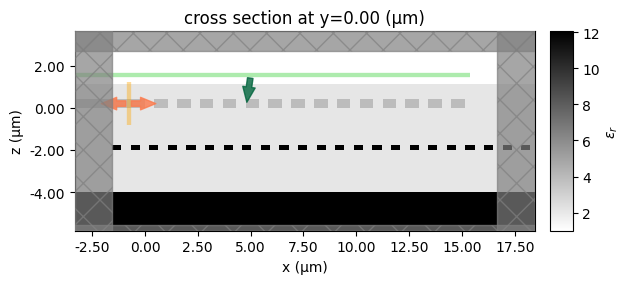

In [17]:
sim = make_2D_full_grating_sim(2)

sim.plot_eps(y=0)
plt.show()

Now we perform parameter sweep of the interlayer distance to maximize the coupling efficiency. 

11:48:01 Eastern Standard Time Running 21 Simulations

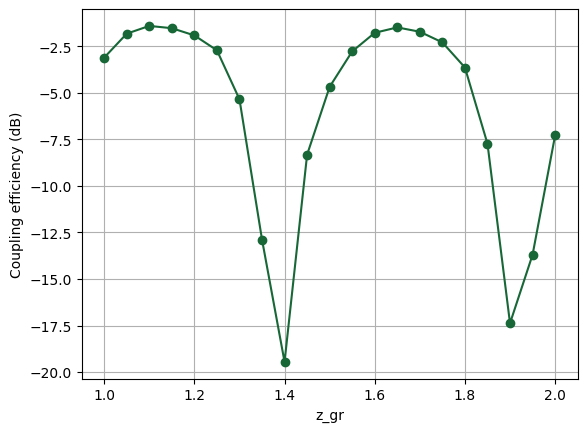

z_gr  coupling efficiency
2   1.10            -1.404425
13  1.65            -1.484064
3   1.15            -1.526486
14  1.70            -1.717543
12  1.60            -1.774490
1   1.05            -1.820092
4   1.20            -1.914278
15  1.75            -2.289349
5   1.25            -2.713833
11  1.55            -2.773200
0   1.00            -3.106520
16  1.80            -3.638100
10  1.50            -4.675568
6   1.30            -5.345168
20  2.00            -7.289271
17  1.85            -7.731516
9   1.45            -8.319647
7   1.35           -12.881006
19  1.95           -13.697595
18  1.90           -17.376482
8   1.40           -19.452692

In [18]:
# Design parameter and bound
params = [
    tdd.ParameterFloat(name="z_gr", span=(1, 2), num_points=21),
]

# Perform parameter sweep
design_space = tdd.DesignSpace(method=method, parameters=params, path_dir="./data")
results = design_space.run(make_2D_full_grating_sim, coupling_efficiency)

# Plot the coupling efficiency as a function of z_gr
df = results.to_dataframe()
plt.plot(df["z_gr"], df["coupling efficiency"], marker="o")
plt.xlabel("z_gr")
plt.ylabel("Coupling efficiency (dB)")
plt.grid(True)
plt.show()

# Extract the best z_gr
best_row = df.loc[df["coupling efficiency"].idxmax()]
best_z_gr = best_row["z_gr"]
df.sort_values(by="coupling efficiency", ascending=False)

Plot the coupling efficiency spectrum for the current best design. A peak coupling efficiency of ~1.5dB is achieved.

11:48:40 Eastern Standard Time Created task 'Optimized 2D uniform grating' with 
                               task_id                                          
                               'fdve-b4d02f11-92cc-4220-aebb-1065f12e8c3c' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=560747;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4d02f11-92cc-4220-aebb-1065f12e8c3c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=721670;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4d02f11-92cc-4220-aebb-1065f12e8c3c\taskId]8;;\
                               ]8;id=560747;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4d02f11-92cc-4220-aebb-1065f12e8c3c\=]8;;\]8;id=426292;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4d02f11-92cc-4220-aebb-1065f12e8c3c\fdve]8;;\]8;id=560747;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4d02f11-92cc-4220-aebb-1065f12e8c3c\-b4d02f11-92cc-4220-aebb-1065f12e8c3c']8;;\.

                               Task folder: ]8;id=746038;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

11:48:41 Eastern Standard Time Maximum FlexCredit cost: 0.025. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

11:48:42 Eastern Standard Time status = success

Output()

11:48:43 Eastern Standard Time loading simulation from simulation_data.hdf5

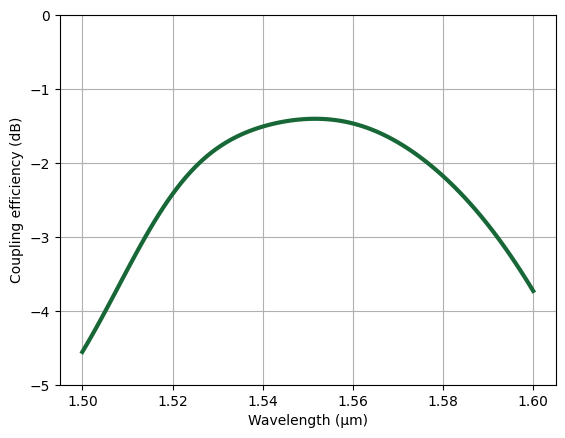

In [19]:
sim = make_2D_full_grating_sim(best_z_gr)
sim_data = web.run(sim, "Optimized 2D uniform grating")
ce = 20 * np.log10(np.abs(sim_data["mode"].amps.sel(mode_index=0, direction="-").values))
plt.plot(ldas, ce, linewidth=3)
plt.ylim(-5, 0)
plt.grid()
plt.xlabel("Wavelength (µm)")
plt.ylabel("Coupling efficiency (dB)")
plt.show()

## Inverse Design Optimization of the SiN Grating

Finally, we perform gradient-based optimization (inverse design) to fine tune the grating. This allows each tooth width and spacing to vary independently, matching the mode profile of the fiber for maximum coupling efficiency.

In [20]:
def make_2D_apodized_grating_sim(design_params: np.ndarray) -> td.Simulation:
    """
    Creates a 2D Tidy3D simulation for an aperiodic grating coupler.

    Parameters
    ----------
    design_params : list[float]
        A list of widths defining the grating structure.
        Even indices (0, 2, ...) correspond to etched widths.
        Odd indices (1, 3, ...) correspond to SiN tooth widths.

    Returns
    -------
    td.Simulation
        Tidy3D simulation object.
    """

    widths_SiN = design_params[1::2]  # SiN tooth widths
    widths_void = design_params[::2]  # Etched widths

    # Create SiN grating geometries from the given widths
    gratings = 0
    center = 0
    for width_SiN, width_void in zip(widths_SiN, widths_void):
        center += width_void + width_SiN / 2  # Update center position
        size = width_SiN
        gratings += td.Box(center=(center, 0, t_SiN / 2), size=(size, td.inf, t_SiN))
        center += width_SiN / 2  # Update center position

    gratings_SiN = td.Structure(geometry=gratings, medium=SiN)

    # Create Si grating reflector structure
    gratings_Si = make_2D_Si_grating(best_w_gr, best_p_gr, z_gr=best_z_gr)

    # Create Si substrate structure
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff),
            rmax=(inf_eff, inf_eff, -best_z_gr - t_box),
        ),
        medium=Si,
    )

    l = 16  # Fix simulation domain size in the x direction

    # Define simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-lda0, 0, -best_z_gr - t_box - lda0),
        rmax=(l + lda0, 0, t_SiN + t_clad + lda0),
    )

    # Create a Tidy3D simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=grid_spec,
        run_time=run_time,
        structures=[oxide_layer, gratings_SiN, gratings_Si, waveguide, substrate],
        sources=[gaussian_beam],
        monitors=[mode_monitor],
        boundary_spec=boundary_spec,
    )
    return sim

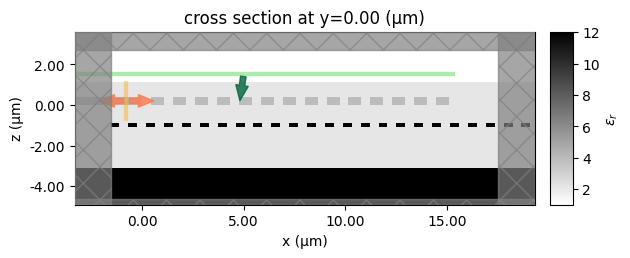

In [21]:
design_params0 = np.array([best_w_gc, best_p_gc - best_w_gc] * n_gc)
sim = make_2D_apodized_grating_sim(design_params0)

sim.plot_eps(y=0)
plt.show()

Define the objective function, which is the coupling efficiency at 1550 nm.

In [22]:
def J(design_params: np.ndarray) -> np.ndarray:
    """
    Compute the coupling efficiency (CE) for a given set of design parameters.

    Parameters
    ----------
    design_params: np.ndarray
        A 1D numpy array containing the design parameters for the grating.

    Returns
    -------
        The coupling efficiency
    """

    sim = make_2D_apodized_grating_sim(design_params)
    sim_data = web.run(sim, task_name="GC_invdes", verbose=False)

    # Extract the complex amplitude of the desired mode at frequency freq0.
    amp = sim_data["mode"].amps.sel(mode_index=0, f=freq0, direction="-").values

    # Coupling efficiency is the squared magnitude of the amplitude.
    ce = np.abs(amp) ** 2

    return ce

Before actually running the inverse design loop, we first test the gradient calculation to ensure it works well. 

In [23]:
dJ = ag.value_and_grad(J)
val, grad = dJ(design_params0)
print(val)
print(grad)

0.7236100065129941
[ 0.22307575  0.56603593  0.51706766  0.41977405  0.3905873  -0.03293696
 -0.27843539 -0.47574742 -0.70943264 -0.75728147 -0.41855601 -0.49909601
 -0.2300799  -0.29551694 -0.27728662 -0.32593653 -0.24543892 -0.26322852
 -0.14479698 -0.15561174 -0.11804074 -0.13953611 -0.09500033 -0.10664506
 -0.05071084 -0.06030557 -0.01361688 -0.01446665]


Now we iteratively improve the design. Here we use the Adam optimizer from `optax`.

In [24]:
# Hyperparameters
num_steps = 80
learning_rate = 0.005
min_feature = 0.1
# Initialize the adam optimizer with starting parameters
params = design_params0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# Store history
J_history = []
params_history = []

for i in range(num_steps):
    # Compute gradient and current objective function value
    value, gradient = dJ(params)

    # Outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.3e}")

    # Compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)
    params = np.clip(params, a_min=min_feature, a_max=None)

    # Save history
    J_history.append(value)
    params_history.append(params)

step = 1
	J = 7.236e-01
step = 2
	J = 7.380e-01
step = 3
	J = 7.433e-01
step = 4
	J = 7.430e-01
step = 5
	J = 7.416e-01
step = 6
	J = 7.438e-01
step = 7
	J = 7.455e-01
step = 8
	J = 7.467e-01
step = 9
	J = 7.468e-01
step = 10
	J = 7.481e-01
step = 11
	J = 7.501e-01
step = 12
	J = 7.520e-01
step = 13
	J = 7.540e-01
step = 14
	J = 7.548e-01
step = 15
	J = 7.564e-01
step = 16
	J = 7.559e-01
step = 17
	J = 7.570e-01
step = 18
	J = 7.581e-01
step = 19
	J = 7.588e-01
step = 20
	J = 7.604e-01
step = 21
	J = 7.615e-01
step = 22
	J = 7.621e-01
step = 23
	J = 7.627e-01
step = 24
	J = 7.632e-01
step = 25
	J = 7.636e-01
step = 26
	J = 7.646e-01
step = 27
	J = 7.635e-01
step = 28
	J = 7.646e-01
step = 29
	J = 7.655e-01
step = 30
	J = 7.665e-01
step = 31
	J = 7.676e-01
step = 32
	J = 7.686e-01
step = 33
	J = 7.696e-01
step = 34
	J = 7.698e-01
step = 35
	J = 7.703e-01
step = 36
	J = 7.705e-01
step = 37
	J = 7.720e-01
step = 38
	J = 7.721e-01
step = 39
	J = 7.737e-01
step = 40
	J = 7.759e-01
step = 41

After the optimization, we can plot the objective function history to visualize the progress. 

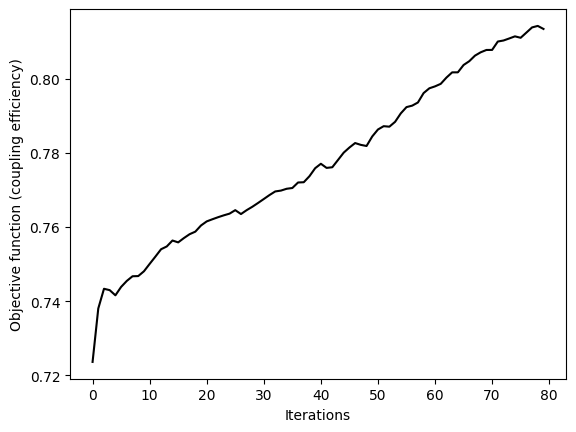

In [25]:
plt.plot(J_history, c="black")
plt.xlabel("Iterations")
plt.ylabel("Objective function (coupling efficiency)")
plt.show()

Plot the final design.

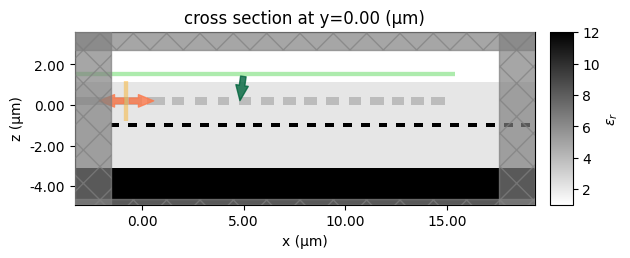

In [26]:
opt_params = params_history[-1]

sim_final = make_2D_apodized_grating_sim(opt_params)

sim_final.plot_eps(y=0)
plt.show()

Plot the coupling efficiency spectrum of the inverse designed grating coupler against that of the periodic one. A significant improvement can be observed. The coupling efficiency is improved from ~1.5dB to sub dB level.

12:43:24 Eastern Standard Time Created task 'Final design' with task_id         
                               'fdve-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=750731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=179076;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f\taskId]8;;\
                               ]8;id=750731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f\=]8;;\]8;id=396132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f\fdve]8;;\]8;id=750731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f\-4d43c8c5-bd1c-4e13-a6f5-cb793a9a082f']8;;\.

                               Task folder: ]8;id=749785;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

12:43:25 Eastern Standard Time Maximum FlexCredit cost: 0.025. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

12:43:26 Eastern Standard Time status = success

Output()

12:43:27 Eastern Standard Time loading simulation from simulation_data.hdf5

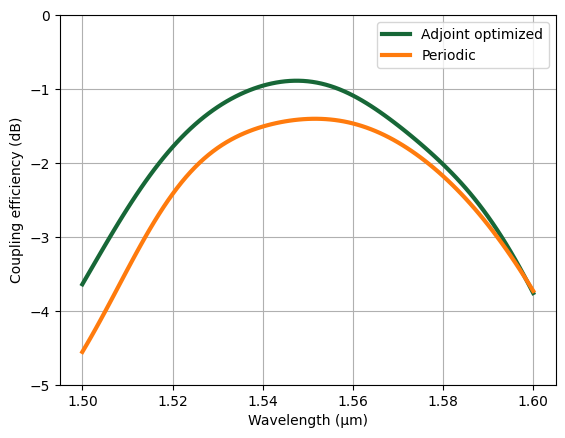

In [27]:
sim_data_final = web.run(sim_final, "Final design")

ce_final = 20 * np.log10(
    np.abs(sim_data_final["mode"].amps.sel(mode_index=0, direction="-").values)
)
plt.plot(ldas, ce_final, linewidth=3, label="Adjoint optimized")
plt.plot(ldas, ce, linewidth=3, label="Periodic")
plt.ylim(-5, 0)
plt.grid()
plt.xlabel("Wavelength (µm)")
plt.ylabel("Coupling efficiency (dB)")
plt.legend()
plt.show()

Finally, we can visually inspect the change of the design parameters. Interestingly, we can see that the most significant change occurs in the first few grating periods. The middle parts of the grating is largely unchanged.

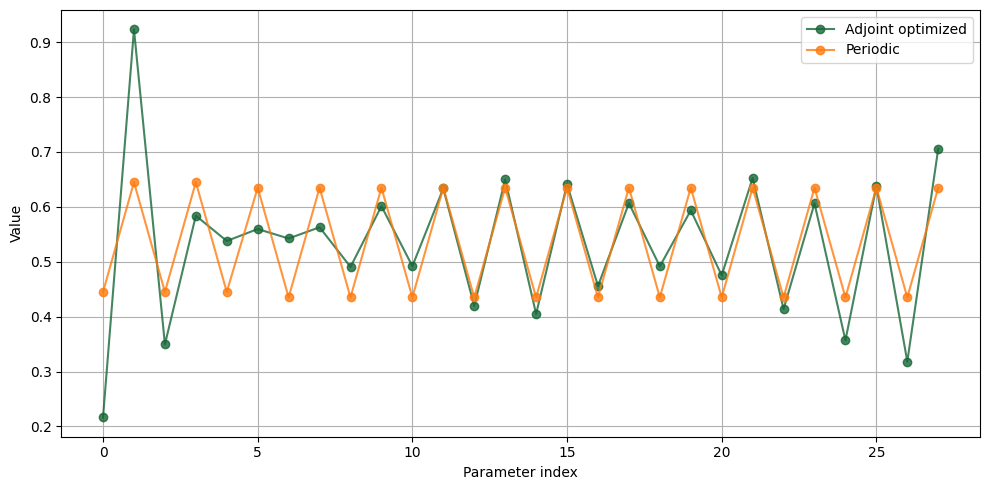

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(opt_params, "o-", label="Adjoint optimized", alpha=0.8)
plt.plot(design_params0, "o-", label="Periodic", alpha=0.8)
plt.xlabel("Parameter index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Notes

In this notebook we perform all simulations in 2D, which is a cost effective and reasonably accurate way of modeling and optimizing the grating coupler. In the next step, we need to create the full grating in 3D (either a linear or focusing configuration) to verify and possibly further optimize the performance. 